# TP Integrador análisis de datos:

Se propone realizar el ciclo completo del desarrollo de un modelo de aprendizaje automático supervisado. Trabajaremos con un dataset de Kaggle con datos de por distintas estaciones metereológicas de Australia. El objetivo es predecir si lloverá o no al día siguiente (variable RainTomorrow), en función datos metereológicos del día actual.


In [4]:
# Importamos librerías:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
sns.set_theme()

In [5]:
df = pd.read_csv("weatherAUS.csv", parse_dates=["Date"])

In [6]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           145460 non-null  datetime64[ns]
 1   Location       145460 non-null  object        
 2   MinTemp        143975 non-null  float64       
 3   MaxTemp        144199 non-null  float64       
 4   Rainfall       142199 non-null  float64       
 5   Evaporation    82670 non-null   float64       
 6   Sunshine       75625 non-null   float64       
 7   WindGustDir    135134 non-null  object        
 8   WindGustSpeed  135197 non-null  float64       
 9   WindDir9am     134894 non-null  object        
 10  WindDir3pm     141232 non-null  object        
 11  WindSpeed9am   143693 non-null  float64       
 12  WindSpeed3pm   142398 non-null  float64       
 13  Humidity9am    142806 non-null  float64       
 14  Humidity3pm    140953 non-null  float64       
 15  

### Observaciones:
* 145460 registros.
* 23 características.
* Existen 17 características númericas y 6 categoricas.

## Análisis de faltantes:

In [52]:
df.isnull().sum()

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64

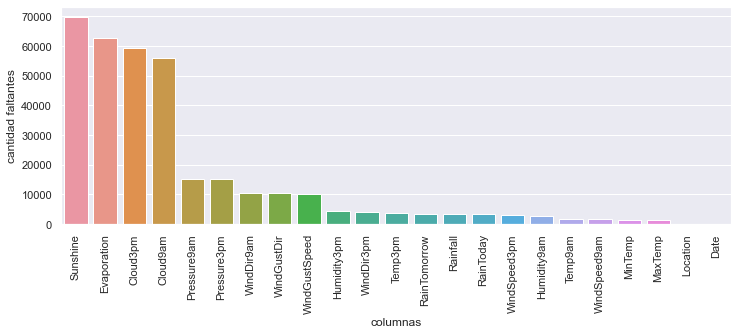

In [51]:
# Verificamos valores faltantes
faltantes = np.sum(df.isnull()).sort_values(ascending=False)
faltantes_df = faltantes.to_frame().reset_index()
faltantes_df.columns = ["columnas","cantidad faltantes"]
figure(figsize=(12,4))
plt.xticks(rotation=90)
ax = sns.barplot(x="columnas", y="cantidad faltantes", data=faltantes_df)

### Observaciones:
* La columna "Sunshine" es la características que posee mayor cantidad de faltantes.
* Las columnas "Sunshine", "Evaporation", "Cloud3pm" y "Cloud9am" son las que mayor número de faltantes posee.
* El resto de las columnas posee un número de faltantes por debajo al 10%.
* Las columnas "Dates" y "Location" no poseen nulos.
* La variable "RainToday" posse 3261 valores nulos.
* La variable objetivo "RainTomorrow" poseen 3267 valores nulos.
* 1855 registros son null ambas variables "RainToday" y "RainTomorrow"

## Análisis de variables categóricas:

In [9]:
# Analizamos las variables categoricas:
df.describe(include='object')

,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow
count,145460,135134,134894,141232,142199,142193
unique,49,16,16,16,2,2
top,Canberra,W,N,SE,No,No
freq,3436,9915,11758,10838,110319,110316


### Faltantes:

In [119]:
# Verificamos valores faltantes de las variables categoricas
faltantes_cat = np.sum(df[["Location", "WindGustDir", "WindDir9am", "WindDir3pm", "RainToday", "RainTomorrow", "Date"]].isnull()).sort_values(ascending=False)
faltantes_cat

WindDir9am      10566
WindGustDir     10326
WindDir3pm       4228
RainTomorrow     3267
RainToday        3261
Location            0
Date                0
dtype: int64

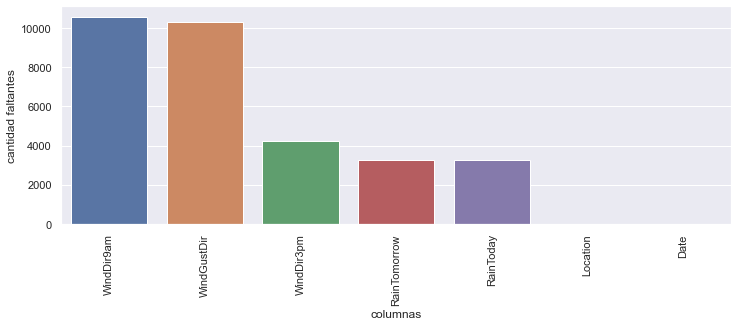

In [120]:
faltantes_cat_df = faltantes_cat.to_frame().reset_index()
faltantes_cat_df.columns = ["columnas","cantidad faltantes"]
figure(figsize=(12,4))
plt.xticks(rotation=90)
ax = sns.barplot(x="columnas", y="cantidad faltantes", data=faltantes_cat_df)

### Location:

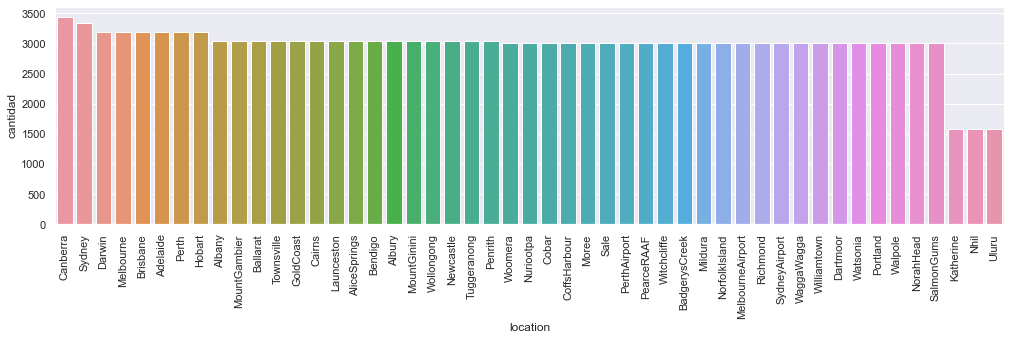

In [30]:
location = df['Location'].value_counts()
location_df = location.to_frame().reset_index()
location_df.columns = ["location","cantidad"]
figure(figsize=(17,4))
plt.xticks(rotation=90)
ax = sns.barplot(x="location", y="cantidad", data=location_df)

* El data set esta distribuido en 49 provincias 

### WindGustDir:

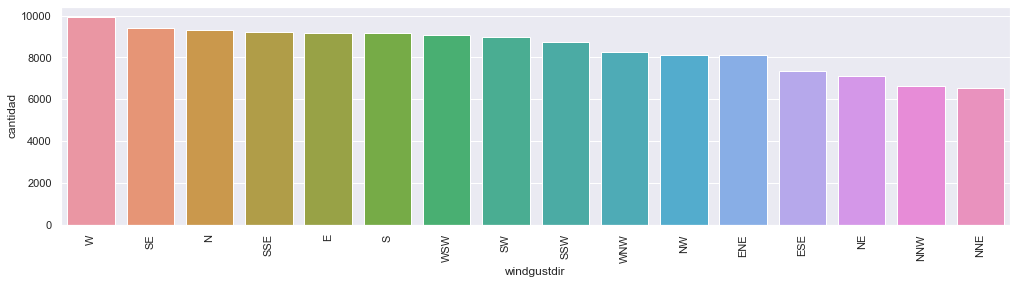

In [37]:
windgustdir = df['WindGustDir'].value_counts()
windgustdir_df = windgustdir.to_frame().reset_index()
windgustdir_df.columns = ["windgustdir","cantidad"]
figure(figsize=(17,4))
plt.xticks(rotation=90)
ax = sns.barplot(x="windgustdir", y="cantidad", data=windgustdir_df)

### WindDir9am:

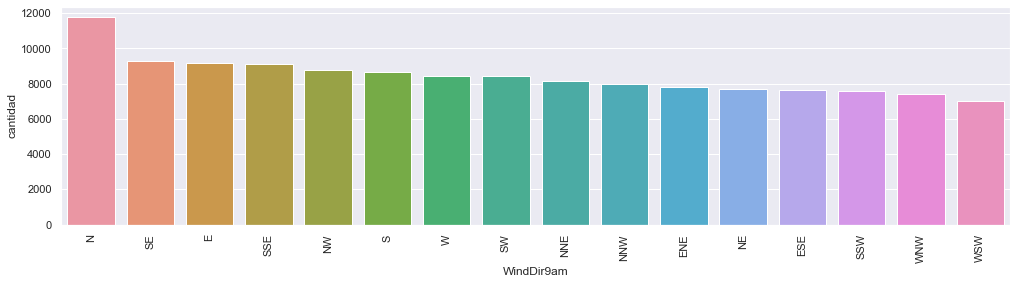

In [36]:
winddir9am = df['WindDir9am'].value_counts()
winddir9am_df = winddir9am.to_frame().reset_index()
winddir9am_df.columns = ["WindDir9am","cantidad"]
figure(figsize=(17,4))
plt.xticks(rotation=90)
ax = sns.barplot(x="WindDir9am", y="cantidad", data=winddir9am_df)

### WindDir3pm:

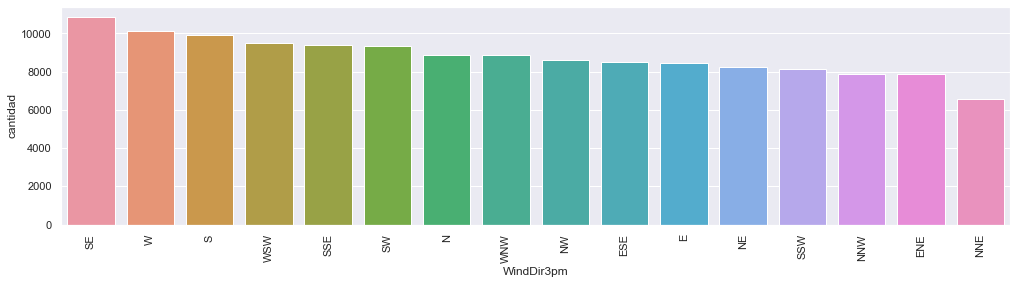

In [38]:
winddir3pm = df['WindDir3pm'].value_counts()
winddir3pm_df = winddir3pm.to_frame().reset_index()
winddir3pm_df.columns = ["WindDir3pm","cantidad"]
figure(figsize=(17,4))
plt.xticks(rotation=90)
ax = sns.barplot(x="WindDir3pm", y="cantidad", data=winddir3pm_df)

### Date:

In [112]:
year = pd.to_datetime(df.Date).dt.year.value_counts()
year

2016    17934
2014    17885
2015    17885
2009    16789
2010    16782
2013    16415
2012    15409
2011    15407
2017     8623
2008     2270
2007       61
Name: Date, dtype: int64

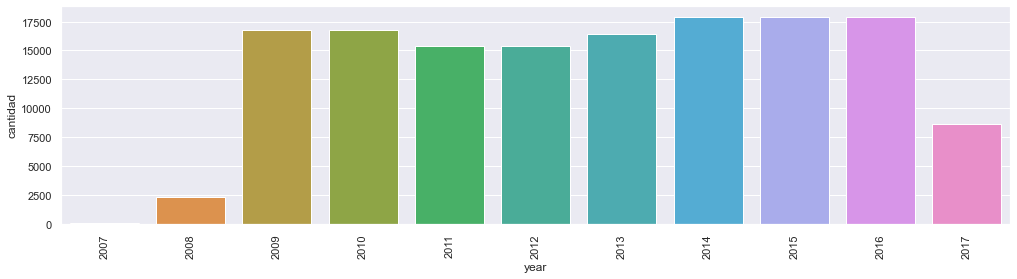

In [110]:
year = pd.to_datetime(df.Date).dt.year.value_counts()
year_df = year.to_frame().reset_index()
year_df.columns = ["year","cantidad"]
figure(figsize=(17,4))
plt.xticks(rotation=90)
ax = sns.barplot(x="year", y="cantidad", data=year_df)

### RainToday:

Text(0.5, 1.0, 'Porcentaje')

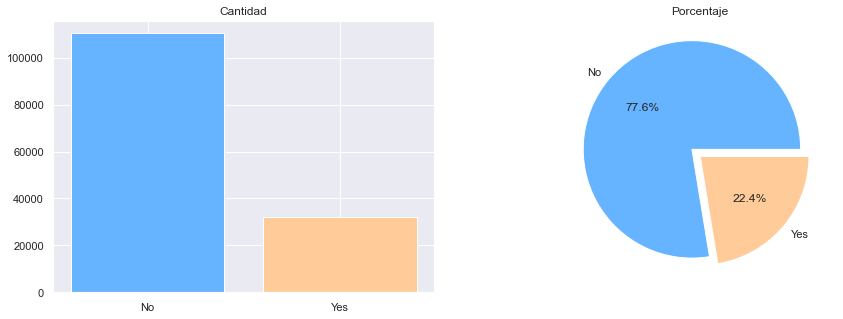

In [83]:
raintoday = df['RainToday'].value_counts()
raintoday_df = raintoday.to_frame().reset_index()
raintoday_df.columns = ["RainToday","porcentaje"]

fig = plt.figure(figsize=(15,5))

ax1=plt.subplot(121)
ax1.bar(raintoday_df["RainToday"], raintoday_df["porcentaje"], color=['#66b3ff','#ffcc99'])
ax1.set_title('Cantidad')

ax1=plt.subplot(122)
ax1.pie(raintoday.values/ len(df) * 100, explode=(0.1, 0),labels=raintoday.index, autopct='%1.1f%%', colors=['#66b3ff','#ffcc99'])
ax1.set_title('Porcentaje')

### RainTomorrow:

Text(0.5, 1.0, 'Porcentaje')

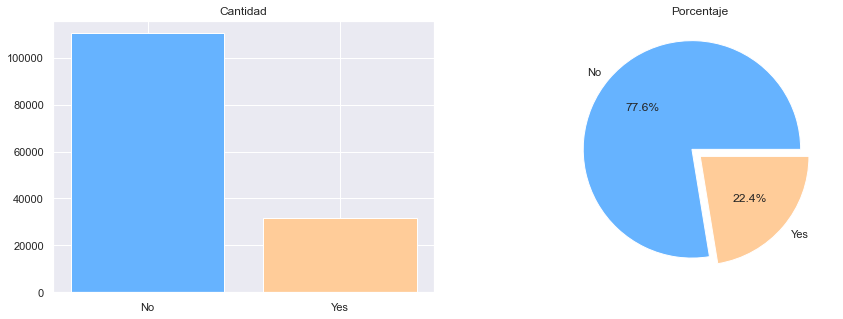

In [80]:
raintomorrow = df['RainTomorrow'].value_counts()
raintomorrow_df = raintomorrow.to_frame().reset_index()
raintomorrow_df.columns = ["RainTomorrow","porcentaje"]

fig = plt.figure(figsize=(15,5))

ax1=plt.subplot(121)
ax1.bar(raintomorrow_df["RainTomorrow"], raintomorrow_df["porcentaje"], color=['#66b3ff','#ffcc99'])
ax1.set_title('Cantidad')

ax1=plt.subplot(122)
ax1.pie(raintomorrow.values/ len(df) * 100, explode=(0.1, 0),labels=raintomorrow.index, autopct='%1.1f%%', colors=['#66b3ff','#ffcc99'])
ax1.set_title('Porcentaje')
